<a href="https://colab.research.google.com/github/ashish26560/movie-recommedation-system/blob/main/recommend.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [12]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
import re
from sklearn.metrics.pairwise import cosine_similarity
import random
import nltk

nltk.download('punkt')
nltk.download('stopwords')

movies = pd.read_csv('movies.csv')
movies['title'] = movies['title'].str.strip().str[:-7]
movies['genres'] = movies['genres'].str.replace('|', ' ')
user_ratings = pd.read_csv('ratings.csv')
user_ratings = user_ratings.drop(columns=['timestamp'])

movies.head()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


,movieId,title,genres
0,1,Toy Story,Adventure Animation Children Comedy Fantasy
1,2,Jumanji,Adventure Children Fantasy
2,3,Grumpier Old Men,Comedy Romance
3,4,Waiting to Exhale,Comedy Drama Romance
4,5,Father of the Bride Part II,Comedy


In [14]:

vectorizer = CountVectorizer()
x = vectorizer.fit_transform(movies['genres'].values)
feature_names = vectorizer.get_feature_names()

In [16]:
genres_bow = pd.DataFrame(x.toarray(), columns=feature_names)
genres_bow['combined']= genres_bow.values.tolist()

In [18]:
movies['genres'] = genres_bow['combined']
movies.head()

,movieId,title,genres
0,1,Toy Story,"[0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ..."
1,2,Jumanji,"[0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ..."
2,3,Grumpier Old Men,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,4,Waiting to Exhale,"[0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ..."
4,5,Father of the Bride Part II,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [19]:
def get_cossim(movieid, top):
    # Creating dataframe with only IDs and genres
    movies_to_search = movies[['movieId', 'genres']]
    # Remove the ID of the movie we are measuring distance to
    movies_to_search = movies_to_search[movies_to_search.movieId != movieid]
    # Saving distances to new column
    movies_to_search['dist'] = movies_to_search['genres'].apply(lambda x: cosine_similarity(np.array(x).reshape(1, -1), np.array(movies.loc[movies['movieId'] == movieid]['genres'].values[0]).reshape(1, -1)))
    # Remove the genres column
    movies_to_search = movies_to_search.drop(columns=['genres'])
    # Distance value is in the list inside of the list so we need to unpack it
    movies_to_search = movies_to_search.explode('dist').explode('dist')
    # Sort the data and return top values
    return movies_to_search.sort_values(by=['dist'], ascending=False)['movieId'].head(top).values

In [20]:
def get_similar(userid):
    # Take all the movies watched by user
    movies_watched_by_user = user_ratings[user_ratings.userId == user_id]
    # Only 4.5 or higher rating filtered
    movies_watched_by_user = movies_watched_by_user[movies_watched_by_user['rating'] > 4.5]
    # Taking top 20 with highest ratings
    top_movies_user = (movies_watched_by_user.sort_values(by="rating", ascending=False).head(20))
    top_movies_user['watched_movieId'] = top_movies_user['movieId']
    top_movies_user = top_movies_user[['userId', 'watched_movieId']]
    # Find 5 similar movies for each of the selected above
    top_movies_user['similar'] = top_movies_user['watched_movieId'].apply(lambda x: (get_cossim(x, 5)))
    # Remove movies that user have already watched from recommendations
    result = [x for x in np.concatenate(top_movies_user['similar'].values, axis=0).tolist() if x not in top_movies_user.watched_movieId.values.tolist()]
    return result

In [22]:
def get_top(id, top):
    # taking movies that user may like
    smlr = get_similar(id)    
    # Calculating mean rationg for every movie
    movie_data = pd.merge(user_ratings, movies, on='movieId')
    ratings_mean_count = pd.DataFrame(movie_data.groupby('movieId')['rating'].mean())
    ratings_mean_count['rating_counts'] = pd.DataFrame(movie_data.groupby('movieId')['rating'].count())
    # Sorting movies with 10 or more ratings by users
    ratings_mean_count = ratings_mean_count[ratings_mean_count['rating_counts'] > 10]
    # Returning top N movies sorted by rating
    return ratings_mean_count[ratings_mean_count.index.isin(smlr)].sort_values(by=['rating'], ascending=False).head(top)

In [23]:
df = user_ratings

In [24]:
user_ids = df["userId"].unique().tolist()
# Reassign user IDs
user2user_encoded = {x: i for i, x in enumerate(user_ids)}
userencoded2user = {i: x for i, x in enumerate(user_ids)}

movie_ids = df["movieId"].unique().tolist()
# Reassign movie IDs
movie2movie_encoded = {x: i for i, x in enumerate(movie_ids)}
movie_encoded2movie = {i: x for i, x in enumerate(movie_ids)}

df["user"] = df["userId"].map(user2user_encoded)
df["movie"] = df["movieId"].map(movie2movie_encoded)

num_users = len(user2user_encoded)
num_movies = len(movie_encoded2movie)
df["rating"] = df["rating"].values.astype(np.float32)
# min and max ratings will be used to normalize the ratings later
min_rating = min(df["rating"])
max_rating = max(df["rating"])

print(
    "Number of users: {}, Number of Movies: {}, Min rating: {}, Max rating: {}".format(
        num_users, num_movies, min_rating, max_rating
    )
)

Number of users: 610, Number of Movies: 9724, Min rating: 0.5, Max rating: 5.0


In [25]:
df = df.sample(frac=1, random_state=42)
x = df[["user", "movie"]].values
# Normalize the targets between 0 and 1. Makes it easy to train.
y = df["rating"].apply(lambda x: (x - min_rating) / (max_rating - min_rating)).values
# Assuming training on 90% of the data and validating on 10%.
train_indices = int(0.9 * df.shape[0])
x_train, x_val, y_train, y_val = (
    x[:train_indices],
    x[train_indices:],
    y[:train_indices],
    y[train_indices:],
)

In [26]:
EMBEDDING_SIZE = 50

class RecommenderNet(keras.Model):
    def __init__(self, num_users, num_movies, embedding_size, **kwargs):
        super(RecommenderNet, self).__init__(**kwargs)
        self.num_users = num_users
        self.num_movies = num_movies
        self.embedding_size = embedding_size
        self.user_embedding = layers.Embedding(
            num_users,
            embedding_size,
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-6),
        )
        self.user_bias = layers.Embedding(num_users, 1)
        self.movie_embedding = layers.Embedding(
            num_movies,
            embedding_size,
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-6),
        )
        self.movie_bias = layers.Embedding(num_movies, 1)

    def call(self, inputs):
        user_vector = self.user_embedding(inputs[:, 0])
        user_bias = self.user_bias(inputs[:, 0])
        movie_vector = self.movie_embedding(inputs[:, 1])
        movie_bias = self.movie_bias(inputs[:, 1])
        dot_user_movie = tf.tensordot(user_vector, movie_vector, 2)
        # Add all the components (including bias)
        x = dot_user_movie + user_bias + movie_bias
        # The sigmoid activation forces the rating to between 0 and 1
        return tf.nn.sigmoid(x)

model = RecommenderNet(num_users, num_movies, EMBEDDING_SIZE)
model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(), optimizer=keras.optimizers.Adam(lr=0.0005)
)

In [27]:
history = model.fit(
    x=x_train,
    y=y_train,
    batch_size=64,
    epochs=15,
    verbose=1,
    validation_data=(x_val, y_val),
)

Epoch 1/15
1418/1418 [==============================] - 8s 5ms/step - loss: 0.6704 - val_loss: 0.6274
Epoch 2/15
1418/1418 [==============================] - 7s 5ms/step - loss: 0.6229 - val_loss: 0.6265
Epoch 3/15
1418/1418 [==============================] - 7s 5ms/step - loss: 0.6133 - val_loss: 0.6195
Epoch 4/15
1418/1418 [==============================] - 6s 5ms/step - loss: 0.6080 - val_loss: 0.6154
Epoch 5/15
1418/1418 [==============================] - 6s 5ms/step - loss: 0.6071 - val_loss: 0.6131
Epoch 6/15
1418/1418 [==============================] - 7s 5ms/step - loss: 0.6030 - val_loss: 0.6112
Epoch 7/15
1418/1418 [==============================] - 7s 5ms/step - loss: 0.6014 - val_loss: 0.6089
Epoch 8/15
1418/1418 [==============================] - 6s 4ms/step - loss: 0.6002 - val_loss: 0.6091
Epoch 9/15
1418/1418 [==============================] - 6s 5ms/step - loss: 0.5981 - val_loss: 0.6077
Epoch 10/15
1418/1418 [==============================] - 7s 5ms/step - loss: 0.597

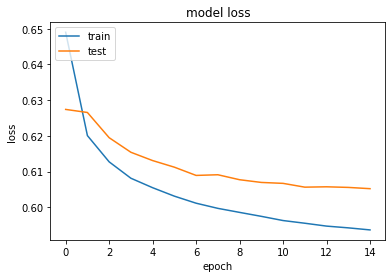

In [34]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc="upper left")
plt.show()

In [36]:
user_id = 10

In [37]:
top = get_top(user_id, 20)
content_rec = top.index.values.tolist()

In [40]:
movie_df = pd.read_csv('movies.csv') 

# Searching for movies that user already watched
movies_watched_by_user = df[df.userId == user_id]
# Searching for movies that user haven't watched yet
movies_not_watched = movie_df[
    ~movie_df["movieId"].isin(movies_watched_by_user.movieId.values)
]["movieId"]

movies_not_watched = list(
    set(movies_not_watched).intersection(set(movie2movie_encoded.keys()))
)

movies_not_watched = [[movie2movie_encoded.get(x)] for x in movies_not_watched]
user_encoder = user2user_encoded.get(user_id)
user_movie_array = np.hstack(
    ([[user_encoder]] * len(movies_not_watched), movies_not_watched)
)
# Predicting ratings for movies
ratings = model.predict(user_movie_array).flatten()
# Sorting predicted ratings and taking top 20
top_ratings_indices = ratings.argsort()[-20:][::-1]
# Getting the actual IDs for movies
recommended_movie_ids = [
    movie_encoded2movie.get(movies_not_watched[x][0]) for x in top_ratings_indices
]


In [41]:
print("Showing recommendations for user: {}".format(user_id))
print("====" * 10)
print("Movies with high ratings from user")
print("----" * 10)
top_movies_user = (
    movies_watched_by_user.sort_values(by="rating", ascending=False)
    .head(10)
    .movieId.values
)
movie_df_rows = movie_df[movie_df["movieId"].isin(top_movies_user)]
for row in movie_df_rows.itertuples():
    print(row.title, ":", row.genres)

print("----" * 10)
print("Top 10 movie recommendations")
print("----" * 10)
# Случайным образом выбираем 10 фильмов из рекомендаций
to_recommend = random.sample((content_rec + recommended_movie_ids), 10)
recommended_movies = movie_df[movie_df["movieId"].isin(to_recommend)]
for row in recommended_movies.itertuples():
    print(row.title, ":", row.genres)

Showing recommendations for user: 10
Movies with high ratings from user
----------------------------------------
Troy (2004) : Action|Adventure|Drama|War
First Daughter (2004) : Comedy|Romance
Education, An (2009) : Drama|Romance
Despicable Me (2010) : Animation|Children|Comedy|Crime
King's Speech, The (2010) : Drama
Dark Knight Rises, The (2012) : Action|Adventure|Crime|IMAX
Intouchables (2011) : Comedy|Drama
Skyfall (2012) : Action|Adventure|Thriller|IMAX
Spectre (2015) : Action|Adventure|Crime
The Intern (2015) : Comedy
----------------------------------------
Top 10 movie recommendations
----------------------------------------
Shawshank Redemption, The (1994) : Crime|Drama
Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bomb (1964) : Comedy|War
Raiders of the Lost Ark (Indiana Jones and the Raiders of the Lost Ark) (1981) : Action|Adventure
Great Escape, The (1963) : Action|Adventure|Drama|War
View to a Kill, A (1985) : Action|Adventure|Thriller
Boondock Saints, Th